# Workshop 2 - Implementation
    
In this notebook you will continue to implement the matrix method and check it with some sanity checks.

> ### Task 0
>
> Check whether your implementation of last week was correct using the provided solution

In [12]:
import numpy as np
import matrixmethod as mm
%config InlineBackend.figure_formats = ['svg']

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. The Node class
The `Node` class from last week is unchanged and complete

## 2. The Element class

The implementation is incomplete:
- The function `add_distributed_load` should compute the equivalent load vector for a constant load $q$ and moves those loads to the nodes belonging to the element. Remember to use the `add_load` function of the `Node` class to store the equivalent loads (remember we have two nodes per element). Also keep local/global transformations in mind and store `self.q = q` for later use;
- The function `bending_moments` receives the nodal displacements of the element in the global coordinate system (`u_global`) and uses it to compute the value of the bending moment at `num_points` equally-spaced points along the element length. Keep local/global transformations in mind and use the ODE approach in SymPy / Maple / pen and paper to compute an expression for $M$. Do the same for for $w$ in the function `full_displacement`.

> ### Task 2.1
>
> Add the missing pieces to the code, before you perform the checks below.

> ### Task 2.2
>
> Having made your implementations, it is now time to verify the first addition of your code with a simple sanity check. We would like to solve the following simply-supported beam:
> <center>
>  <figure>
>    <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/ssbeam.png" WIDTH=200>
>  </figure>
></center>
>
> Choose appropriate values yourself.
>
> Use the code blocks below to set up this problem. After you've added the load, print the element using `print(YOUR ELEMENT)`. Do the shown values for the nodal loads correspond with what you'd expect?

In [13]:
mm.Node.clear()
mm.Element.clear()

node1 = mm.Node(x=0, z=0)
node2 = mm.Node(x=1, z=0)

elem = mm.Element(node1, node2)

section = {}
section['EI'] = 1000

elem.set_section(section)
elem.add_distributed_load([0,2])

In [14]:
print(elem)

Element connecting:
node #1:
 This node has:
 - x coordinate=0,
 - z coordinate=0,
 - degrees of freedom=[0, 1, 2],
 - load vector=[ 0.          1.         -0.16666667]
with node #2:
 This node has:
 - x coordinate=1,
 - z coordinate=0,
 - degrees of freedom=[3, 4, 5],
 - load vector=[0.         1.         0.16666667]


> ### Task 2.3
>  Now solve the nodal displacements. Once you are done, compare the rotation at the right end of the beam. Does it match the solution you already know?

In [15]:
con = mm.Constrainer()
con.fix_dof(node1, 0)
con.fix_dof(node1, 1)
con.fix_dof(node2, 1)

global_k = elem.stiffness()
global_f = np.zeros(6)

global_f[0:3] = node1.p
global_f[3:6] = node2.p

Kff, Fff = con.constrain(global_k, global_f)
u = np.matmul(np.linalg.inv(Kff), Fff)
print(u)

[-8.33333333e-05  0.00000000e+00  8.33333333e-05]


> ### Task 2.4
> Calculate the bending moment at midspan and plot the moment distribution using `plot_moment_diagram`. Do the values and shape match with what you'd expect?

[ 0.00000000e+00  0.00000000e+00 -8.33333333e-05  0.00000000e+00
  0.00000000e+00  8.33333333e-05]
[0.         0.09876543 0.17283951 0.22222222 0.24691358 0.24691358
 0.22222222 0.17283951 0.09876543 0.        ]
[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


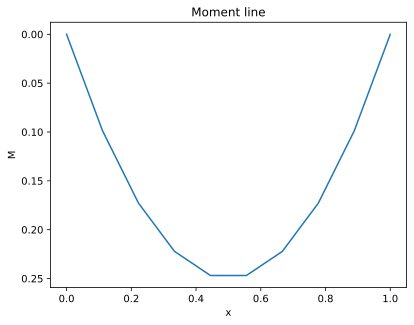

In [16]:
u_elem = con.full_disp(u)
print(u_elem)
elem.plot_moment_diagram(u_elem)

> ### Task 2.5
> Calculate the deflection at midspan and plot the deflected structure using `plot_displaced`. Do the values and shape match with what you'd expect?

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.00000000e+00 9.04333689e-06 1.68927501e-05 2.26337449e-05
 2.56566580e-05 2.56566580e-05 2.26337449e-05 1.68927501e-05
 9.04333689e-06 0.00000000e+00]


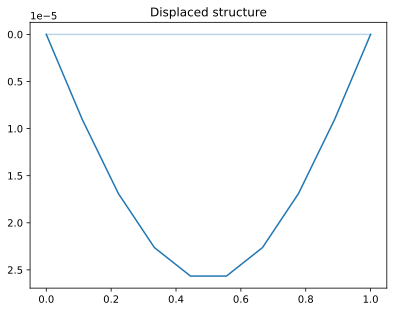

In [17]:
elem.plot_displaced(u_elem)

## 3. The Constrainer class

We're going to expand our Constrainer class, but the implementation is incomplete:
- The constrainer class should be able to handle non-zero boundary conditions too. `constrain` should be adapted to do so + the docstring of the class itself. Furthermore, the assert statement of `fix_dof` should be removed.
- The function `support_reactions` is incomplete. Since the constrainer is always first going to get `constrain` called, here we already have access to `self.free_dofs`. Together with `self.cons_dofs`, you should have all you need to compute reactions. Note that `f` is also passed as argument. Make sure you take into account the contribution of equivalent element loads that go directly into the supports without deforming the structure.

> ### Task 3.1
>
> Add the missing pieces to the code and docstring, before you perform the checks below.

> ### Task 3.2
>
> We're going to verify our implementation. Therefore, we're going to solve an extension bar, supported at both ends, with a load $q$.
> <center>
>  <figure>
>    <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/sanitycheck_3.2.png" WIDTH=200>
>  </figure>
></center>
>
> Choose appropriate values yourself.
>
> Can you say on beforehand what will be the displacements? And what will be the support reactions?
> Use the code blocks below to set up and solve this problem and check the required quantities to make sure your implementation is correct.

In [18]:
mm.Node.clear()
mm.Element.clear()

l = 10

node1 = mm.Node(x=0, z=0)
node2 = mm.Node(x=l, z=0)

elem = mm.Element(node1, node2)

section = {}
section['EI'] = 1000
section['EA'] = 100

elem.set_section(section)
elem.add_distributed_load([1,0])

In [19]:
con = mm.Constrainer()
con.fix_dof(node1, 0)
con.fix_dof(node1, 1)
con.fix_dof(node2, 0)
con.fix_dof(node2, 1)

global_k = elem.stiffness()
global_f = np.zeros(6)

global_f[0:3] = node1.p
global_f[3:6] = node2.p

Kc, Fc = con.constrain ( global_k, global_f )
u_free = np.matmul ( np.linalg.inv(Kc), Fc )
print(u_free)

print(con.support_reactions(global_k,u_free,global_f))



[0. 0.]
[-5.  0. -5.  0.]


> ### Task 3.3
>
> Again, we're going to verify our implementation. Therefore, we're going solve a beam, with a load $F$ and support displacement $\bar w$ for the right support.
> <center>
>  <figure>
>    <IMG SRC="https://raw.githubusercontent.com/ibcmrocha/public/main/sanitycheck_3.3_new.png" WIDTH=200>
>  </figure>
></center>
>
> Choose appropriate values yourself.
>
> Use the code blocks below to set up and solve this problem and check the required quantities to make sure your implementation is correct.

In [20]:
EI = 1000
F  = 10
L  = 1
w_B = 0.1

mm.Node.clear()
mm.Element.clear()

node1 = mm.Node (0,0)
node2 = mm.Node (L,0)
node2.add_load([0,F,0])

elem = mm.Element ( node1, node2 )

section = {}
section['EI'] = EI

elem.set_section (section)

print(elem)

con = mm.Constrainer()

con.fix_node (node1)
con.fix_dof (node2,1,w_B)

print(con)

global_k = elem.stiffness()
global_f = np.zeros (6)

global_f[0:3] = node1.p
global_f[3:6] = node2.p

Kc, Fc = con.constrain ( global_k, global_f )
u_free = np.matmul ( np.linalg.inv(Kc), Fc )
print(u_free)

print(con.support_reactions(global_k,u_free,global_f))

Element connecting:
node #1:
 This node has:
 - x coordinate=0,
 - z coordinate=0,
 - degrees of freedom=[0, 1, 2],
 - load vector=[0. 0. 0.]
with node #2:
 This node has:
 - x coordinate=1,
 - z coordinate=0,
 - degrees of freedom=[3, 4, 5],
 - load vector=[ 0. 10.  0.]
This constrainer has constrained the degrees of freedom: [0, 1, 2, 4] with corresponding constrained values: [0, 0, 0, 0.1])
[ 0.   -0.15]
[   0. -300.  300.  290.]


[-300. -294. -288. -282. -276. -270. -264. -258. -252. -246. -240. -234.
 -228. -222. -216. -210. -204. -198. -192. -186. -180. -174. -168. -162.
 -156. -150. -144. -138. -132. -126. -120. -114. -108. -102.  -96.  -90.
  -84.  -78.  -72.  -66.  -60.  -54.  -48.  -42.  -36.  -30.  -24.  -18.
  -12.   -6.    0.]
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


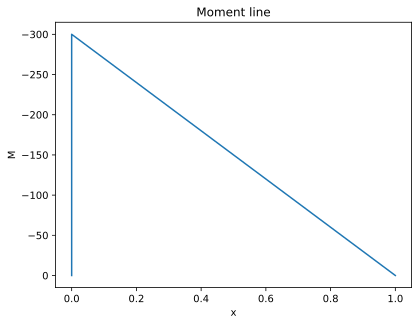

In [21]:
u_elem = con.full_disp(u_free)[elem.global_dofs()]
elem.plot_moment_diagram(u_elem,num_points=51)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[0.00000e+00 5.96000e-05 2.36800e-04 5.29200e-04 9.34400e-04 1.45000e-03
 2.07360e-03 2.80280e-03 3.63520e-03 4.56840e-03 5.60000e-03 6.72760e-03
 7.94880e-03 9.26120e-03 1.06624e-02 1.21500e-02 1.37216e-02 1.53748e-02
 1.71072e-02 1.89164e-02 2.08000e-02 2.27556e-02 2.47808e-02 2.68732e-02
 2.90304e-02 3.12500e-02 3.35296e-02 3.58668e-02 3.82592e-02 4.07044e-02
 4.32000e-02 4.57436e-02 4.83328e-02 5.09652e-02 5.36384e-02 5.63500e-02
 5.90976e-02 6.18788e-02 6.46912e-02 6.75324e-02 7.04000e-02 7.32916e-02
 7.62048e-02 7.91372e-02 8.20864e-02 8.50500e-02 8.80256e-02 9.10108e-02
 9.40032e-02 9.70004e-02 1.00000e-01]


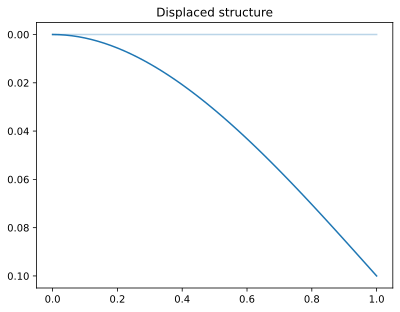

In [22]:
deflections = elem.full_displacement(u_elem,3)
elem.plot_displaced(u_elem,num_points=51,global_c=False)